In [ ]:
# This code mounts your Google Drive to the Google Colab environment.
# It allows you to access files stored in your Google Drive directly from Colab.
# After running this code, you will be prompted to authorize Colab to access your Google Drive.
# Once authorized, you can read from and write to your Google Drive as if it were a local directory.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import math

In [ ]:
# Define Directories
train_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train"
valid_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/valid"
test_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/test"

In [ ]:
# # Mature
# import os
# folder_path = ('/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train/Mature')
# test = os.listdir(folder_path)
# for fichier in test:
#     if not(fichier.endswith(".jpg")):
#         os.remove(os.path.join(folder_path, fichier))

# # Immature
# import os
# folder_path = ('/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train/Immature')
# test = os.listdir(folder_path)
# for fichier in test:
#     if not(fichier.endswith(".jpg")):
#         os.remove(os.path.join(folder_path, fichier))

# # Normal
# import os
# folder_path = ('/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train/Normal')
# test = os.listdir(folder_path)
# for fichier in test:
#     if not(fichier.endswith(".jpg")):
#         os.remove(os.path.join(folder_path, fichier))

In [ ]:
import os
from pathlib import Path
image_dir = Path('/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/Bangkit 2024/Split_Augm...,Normal
1,/content/drive/MyDrive/Bangkit 2024/Split_Augm...,Immature
2,/content/drive/MyDrive/Bangkit 2024/Split_Augm...,Mature


<ipython-input-9-e619146533d5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


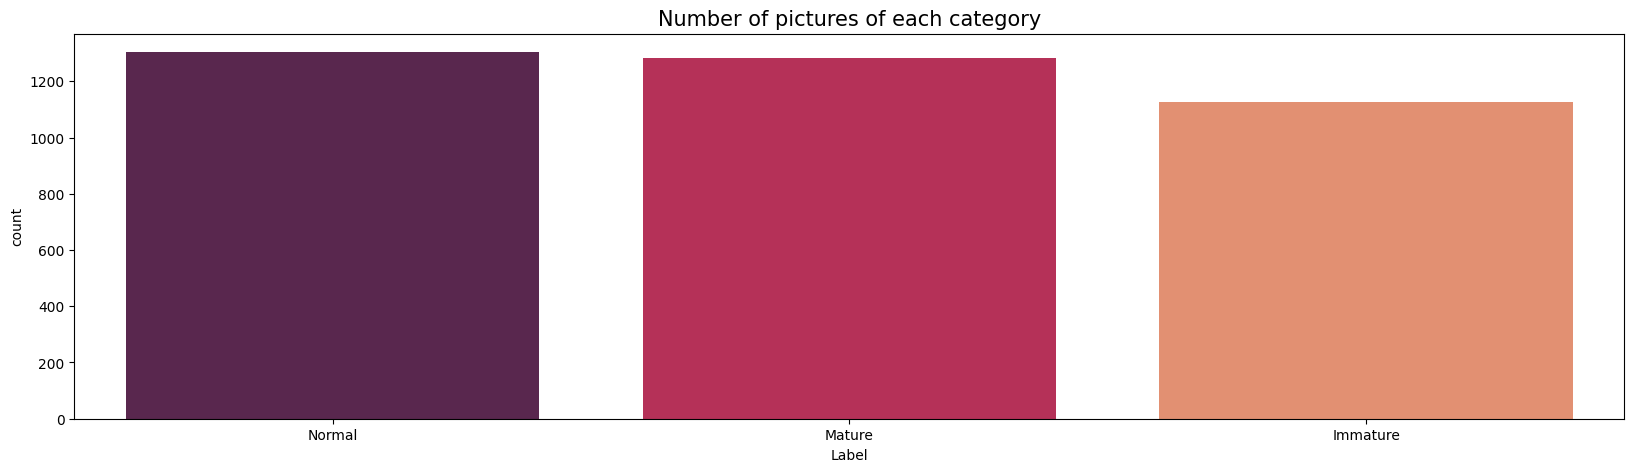

In [ ]:
# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generators with preprocessing for Inception V3
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

# Setting up batch data from directories
train_batches = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

valid_batches = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_batches = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3712 images belonging to 3 classes.
Found 1284 images belonging to 3 classes.
Found 1290 images belonging to 3 classes.


In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-18 23:15:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  68.8MB/s    in 1.2s    

2024-06-18 23:16:01 (68.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from keras import Model, Input
input_shape = (299,299,3)
model_input = Input(shape=input_shape)


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (299, 299, 3),
                                include_top = False,
                                input_tensor=model_input,
                                weights = "imagenet")

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = True


pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
# Choose `mixed_10` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)

# Append the dense network to the base model
inception = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_188[

In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.05 and logs.get('val_accuracy') > 0.90):
      print("\Stopped, Akurasi mencapai 98%")
      self.model.stop_training = True;

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/content/drive/MyDrive/Bangkit 2024/inceptionv3.h5'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Set the training parameters
callbacks= myCallback()
inception.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Train Model
steps_per_epoch = math.ceil(train_batches.samples / train_batches.batch_size)
validation_steps = math.ceil(valid_batches.samples / valid_batches.batch_size)

history = inception.fit(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    verbose=1,
    callbacks=[callbacks, checkpoint_callback])

Epoch 1/30
116/116 [==============================] - ETA: 0s - loss: 1.2769 - accuracy: 0.7737 
Epoch 1: loss improved from inf to 1.27693, saving model to /content/drive/MyDrive/Bangkit 2024/inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 1696s 14s/step - loss: 1.2769 - accuracy: 0.7737 - val_loss: 0.2379 - val_accuracy: 0.9291
Epoch 2/30
116/116 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9962\Stopped, Akurasi mencapai 98%

Epoch 2: loss improved from 1.27693 to 0.01609, saving model to /content/drive/MyDrive/Bangkit 2024/inceptionv3.h5
116/116 [==============================] - 89s 768ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.2626 - val_accuracy: 0.9618


In [ ]:
test_loss, test_accuracy = inception.evaluate(test_batches, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 [==============================] - 406s 10s/step - loss: 0.2555 - accuracy: 0.9736
Test Accuracy: 0.9736
Test Loss: 0.2555


41/41 [==============================] - 12s 237ms/step
Confusion Matrix
[[378   0   0]
 [  7 420  27]
 [  0   0 458]]
Classification Report
              precision    recall  f1-score   support

    Immature       0.98      1.00      0.99       378
      Mature       1.00      0.93      0.96       454
      Normal       0.94      1.00      0.97       458

    accuracy                           0.97      1290
   macro avg       0.98      0.98      0.97      1290
weighted avg       0.97      0.97      0.97      1290



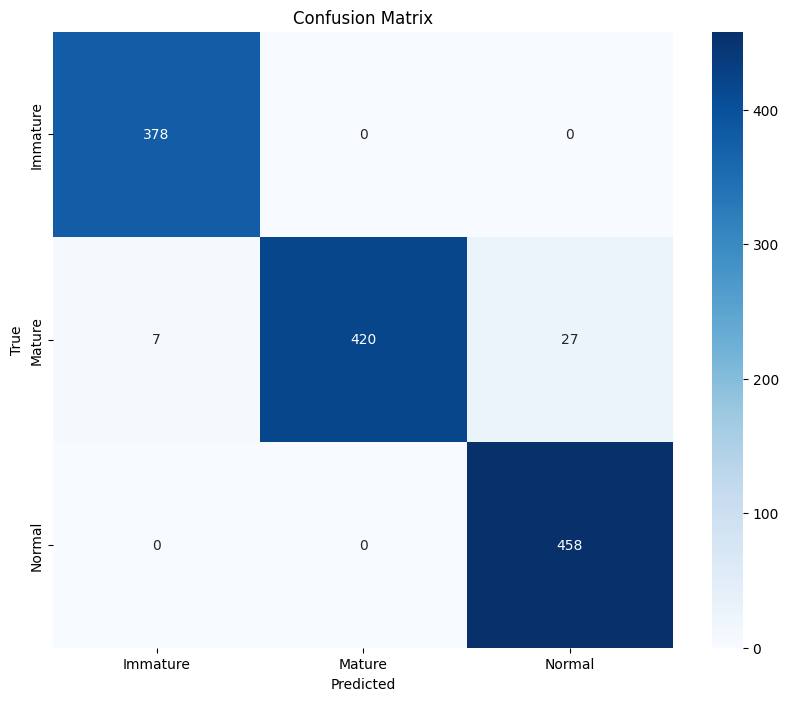

In [ ]:
# Get the class labels
class_labels = list(test_batches.class_indices.keys())

# Reset the test_batches generator
test_batches.reset()

# Predict on the test data
predictions = inception.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_batches.classes

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(conf_matrix)

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

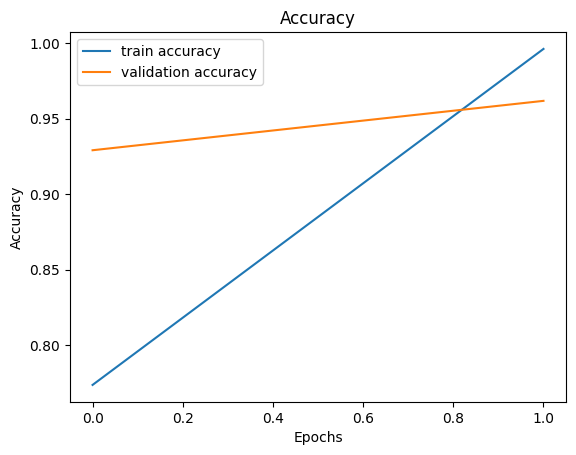

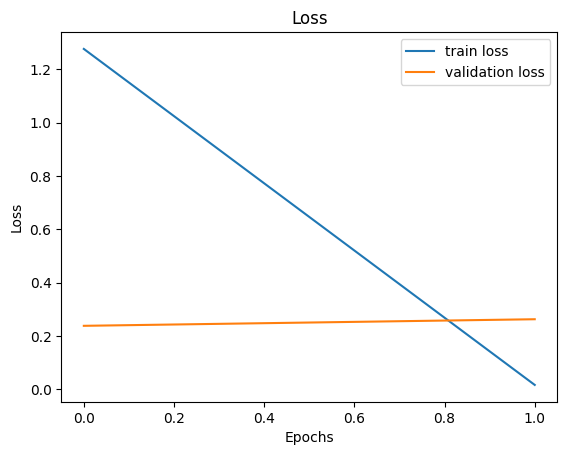

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image with the target size of 299x299
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image using the InceptionV3 preprocess function
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array

# Function to predict the label of the image
def predict_image(image_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    # Make a prediction using the final model
    single_prediction = inception.predict(img_array)
    # Get the predicted class index
    predicted_class = np.argmax(single_prediction, axis=1)
    # Get the predicted label from the class labels
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label

# File upload widget to upload images
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Callback function when a file is uploaded
def on_file_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        # Save the uploaded file
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        # Display the uploaded image
        img = image.load_img(filename, target_size=(299, 299))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # Make a prediction
        predicted_label = predict_image(filename)
        print(f"Predicted Label for {filename}: {predicted_label}")

# Observe changes in the file upload widget
upload_widget.observe(on_file_upload_change, names='value')
# Display the file upload widget
display(upload_widget)


FileUpload(value={}, accept='image/*', description='Upload')

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/Bangkit 2024"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "inceptionv3.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
inception.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/Bangkit 2024/H5/inceptionv3.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
import os

# Load the saved Keras model
print('Loading the saved Keras model...')
model = tf.keras.models.load_model(save_model_path)

# Convert the model to TFLite format
print('Converting to TFLite format...')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Set optimization strategy
converter.target_spec.supported_types = [tf.uint8]  # Ensure the model is saved with UINT8 data type

# Generate the TFLite model
tflite_model = converter.convert()

# Define the TFLite model path
tflite_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "InceptionV3.tflite")

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("The model was successfully converted to TFLite and saved as {}".format(tflite_model_path))

Loading the saved Keras model...


Converting to TFLite format...
The model was successfully converted to TFLite and saved as /content/drive/MyDrive/Bangkit 2024/H5/InceptionV3.tflite


In [ ]:
pip install tflite_support

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Add metadata to the TensorFlow Lite model
print('Adding metadata to the TFLite model...')
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = tflite_model_path
_SAVE_TO_PATH = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "metadata_model.tflite")
_LABEL_FILE = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, "labels.txt")

# Create the labels.txt file with the desired labels
with open(_LABEL_FILE, 'w') as f:
    f.write("Normal\nImmature\nMature\n")

# Load the TFLite model
with open(tflite_model_path, 'rb') as f:
    tflite_model = f.read()

# Create metadata writer and populate metadata
populator = image_classifier.MetadataWriter.create_for_inference(
    model_buffer=tflite_model,
    input_norm_mean=[127.5],  # Normalization mean
    input_norm_std=[127.5],   # Normalization standard deviation
    label_file_paths=[_LABEL_FILE]
)

# Populate metadata
tflite_model_with_metadata = populator.populate()

# Save the TFLite model with metadata
with open(_SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model_with_metadata)

print("The TFLite model with metadata was successfully saved as {}".format(_SAVE_TO_PATH))

Adding metadata to the TFLite model...
The TFLite model with metadata was successfully saved as /content/drive/MyDrive/Bangkit 2024/H5/metadata_model.tflite
